In [1]:
%matplotlib inline
from __future__ import division
from vectors import vec3, cross
from math import cos, sin, pi, sqrt, exp
from itertools import chain
import matplotlib.pyplot as plt
import numpy as np

def flip(triangles):
	#flip the vertex order of a list of triangles
	return map(lambda x : x[::-1], triangles)

def circle(r, n, theta = 0):
	#return a list of n points describing a circle of radius r
	return tuple(vec3(r*cos(2*pi*i/n + theta), r*sin(2*pi*i/n + theta), 0) for i in range(n))

def polar(r , n, theta = 0):
    return tuple(vec3(r(t + theta)*cos(t), r(t + theta)*sin(t), 0) for t in np.linspace(0, 2*pi, n))
    #return tuple(vec3(r(2*pi*i/n)*cos(2*pi*i/n), r(2*pi*i/n)*sin(2*pi*i/n), 0) for i in range(n))

def naive_triangulisation(shape):
	return [[shape[0], shape[n+1], shape[n]] for n in range(1, len(shape) - 1)]

def polytotri(shape):
    return naive_triangulisation(shape)
	#z = shape[0].z
	#from p2t import CDT, Point, Triangle
	#polyline = [Point(p.x, p.y) for p in shape]
	#cdt = CDT(polyline)
	#triangles = cdt.triangulate()
	#points = [[t.a, t.b, t.c] for t in triangles]
	#return [[vec3(p.x, p.y, z) for p in t] for t in points]


def lerp(a,b,l):
	return a*(1-l) + b*l
def lerp_shapes(a,b,l):
	return [i*(1-l) + j*l for i,j in zip(a,b)]

#@memoize
def kochify(shape, iterations, max_iterations = None):
	#applys one iteration of the koch snowflake to an arbitray pointlist.
	if max_iterations == None: max_iterations = iterations
	if max_iterations <= 0: return tuple(shape)
	if 1 <= iterations: l = 1
	if 0 < iterations < 1: l = iterations
	if iterations <= 0: l = 0

	newshape = []
	for i in range(len(shape)):
		a = shape[i]
		b = shape[(i+1)%len(shape)]
		v = b - a
		newshape.append(a)
		newshape.append(lerp(a,b,1/3))
		newshape.append(lerp(a,b,1/2) + l * 1/3 * vec3(v.y, -v.x, 0))
		newshape.append(lerp(a,b,2/3))
	return tuple(kochify(newshape, iterations - 1, max_iterations - 1))

def translate(shape, vector):
	return tuple(point + vector for point in shape)

def join(a, b):
	#assert(len(a) == len(b))
	def half_triangles(a,b,shift): return [[ b[i], a[i], b[(i+shift) % len(a)] ] for i in range(len(a))]
	#return zip(b, a, chain(b[1:], [b[0],])) + zip(a, b, chain([a[-1],],a[:-1]))
	return half_triangles(a,b,+1) + half_triangles(b,a,-1)

def normal(triangle):
	a,b,c = triangle
	return cross(c-a, b-a)

def extrude(shape_func, samples = 50):
	#shape_func = memodict(shape_func)
	triangles = []
	shapes = [shape_func(i/samples) for i in range(samples+1)]
	for i in range(samples):
		triangles += join(shapes[i], shapes[i+1])
	#triangles += flip(polytotri(shapes[0]))# + polytotri( shapes[-1])
	return triangles

#def triangles_to_stl(triangles):
#	s = """
#solid Model
#{}
#endsolid Model
#"""
#	vertex = \
#"""
#facet normal {n[0]:.5f} {n[1]:.5f} {n[2]:.5f}
#	outer loop
#  	vertex {t[0][0]:.5f} {t[0][1]:.5f} {t[0][2]:.5f}
#  	vertex {t[1][0]:.5f} {t[1][1]:.5f} {t[1][2]:.5f}
#  	vertex {t[2][0]:.5f} {t[2][1]:.5f} {t[2][2]:.5f}
#	endloop
#endfacet
#"""
#	vertices = "".join(vertex.format(n = normal(t), t = t) for t in triangles)
#	return s.format(vertices)

def triangles_to_binary_stl(triangles, stl_file):
	from struct import Struct, pack
	header = b"\x00" * 80 + pack("<I", len(triangles))
	stl_file.write(header)
	for t in triangles:
		#n = normal(t)
		data = chain([0,0,0],list(chain.from_iterable(t)),[0,])
		s = Struct("<" + "f" * 12 + "H")
		stl_file.write(s.pack(*data))


def make_stl(name, vase_function, samples = 50):
	with open(name, 'w') as stl_file:
		surface = extrude(vase_function, samples = samples)
		triangles_to_binary_stl(surface, stl_file)
        
pot_diameters = {"small":36.5, "medium":48.3, "big":60}#mm radius


In [2]:
def save_to_stl_and_view(name, poly_func, **kwargs):
    #save the data to an stl file
    make_stl(name + ".stl", poly_func,  **kwargs)


    #bad hack to view the stl
    with open("view.scad", "w") as f:
        f.write('import("{}");'.format(name + ".stl"))

    #convert the stl to png with openscad (yuck)
    from subprocess import check_output, PIPE, STDOUT
    cmd = "openscad -o {0}.png view.scad".format(name)
    print(check_output(cmd, stderr=STDOUT, shell= True))

    from IPython.display import Image
    return Image(filename=name + ".png") 

Compiling design (CSG Products normalization)...
Normalized CSG tree has 1 elements



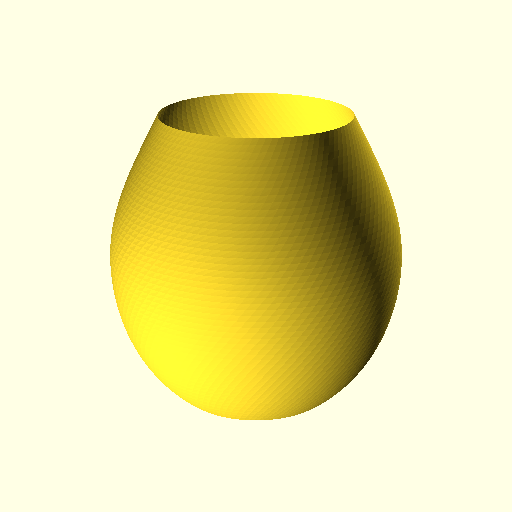

In [3]:
def top_radius(i):
        b=0.56; d=0.71
        c = pi/2.0*(1-b)
        return 0.5 * (sin(b*pi*i + c)**2 + d) / (sin(b*pi*0.5 + c)**2 + d)

def bottom_radius(i):
    j = 0.36
    return sqrt(0.5**2 - (i - 0.5)**2/(1+j))

def bulb_radius(i):
    return top_radius(i) if i > 0.5 else bottom_radius(i)
    

opening_radius = 50.0
def smooth_bulb(i):
    from math import sqrt
    samples = 100
    scale_up = opening_radius / bulb_radius(1.0)

    spin = i* pi/2
    height = 1.0 * scale_up
    r = bulb_radius(i) * scale_up

    c = circle(r, samples, spin)
    return translate(c, [0,0,i*height])


f = smooth_bulb
save_to_stl_and_view("{}_{}mm_opening".format(f.__name__, opening_radius), f)


Compiling design (CSG Products normalization)...
Normalized CSG tree has 1 elements



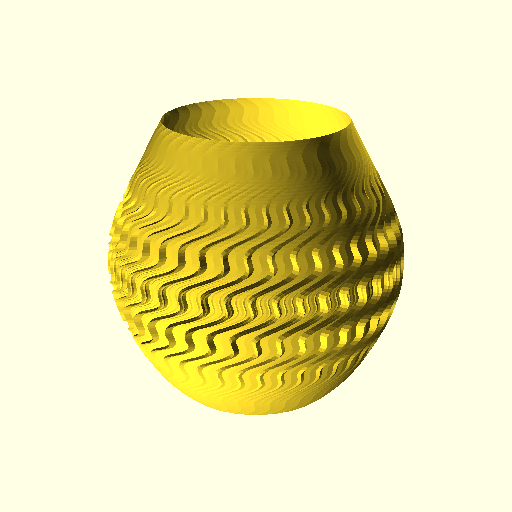

In [4]:
opening_radius = 48.0
def nice_swirl(i):
    samples = 40
    iterations = 2
    scale_up = opening_radius / bulb_radius(1.0)
    height = 1.0 * scale_up
    r = scale_up * bulb_radius(i)
    n = 4.0

    n = 4.0
    lerp_function = 0.6 * i**n * (1 - i)**n / 0.5**(2*n)
    spin = 0.01 * (sin(7.0*i*2*pi) + 0*i) * 2*pi  + 2*i

    c = circle(r, samples * 4**iterations, spin)
    koch = kochify(circle(r, samples, spin), iterations*lerp_function, max_iterations = iterations)
    return translate(koch, [0,0,i*height])


f = nice_swirl
save_to_stl_and_view("{}_{}mm_opening".format(f.__name__, opening_radius), f, samples = 100)

Compiling design (CSG Products normalization)...
Normalized CSG tree has 1 elements



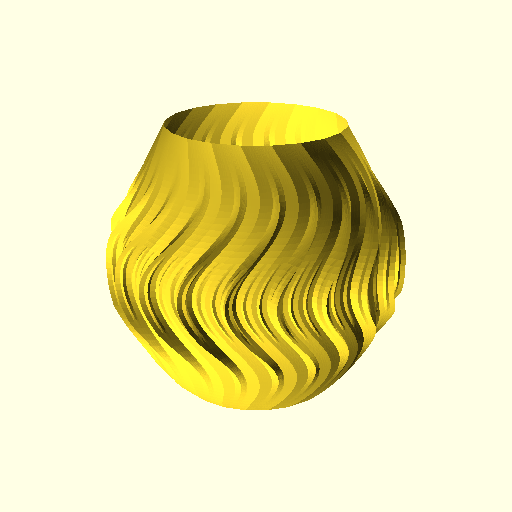

In [5]:
opening_radius = 48.0
def c_shape(i):
    samples = 20
    iterations = 2
    scale_up = opening_radius / bulb_radius(1.0)
    height = 1.0 * scale_up
    r = scale_up * bulb_radius(i)
    n = 4.0

    n = 4.0
    lerp_function = 0.7 * i**n * (1 - i)**n / 0.5**(2*n)
    spin = 0.03 * (sin(1.5*i*2*pi) + 0*i) * 2*pi

    c = circle(r, samples * 4**iterations, spin)
    koch = kochify(circle(r, samples, spin), iterations*lerp_function, max_iterations = iterations)
    return translate(koch, [0,0,i*height])


f = c_shape
save_to_stl_and_view("{}_{}mm_opening".format(f.__name__, opening_radius), f, samples = 50 )

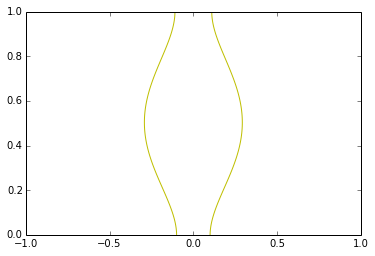

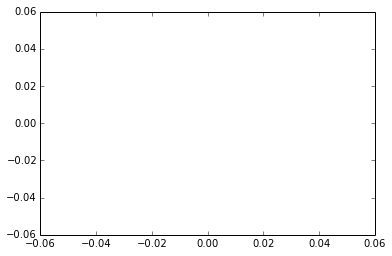

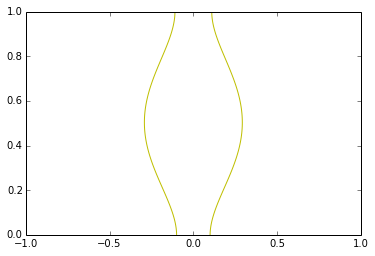

In [6]:
def make_radius_function(a,b,c,d):
    #suggestions:
    #a = 3.0; b = 0.1; c = 0.01; d = 1.1
    def f(x):
        return a*x**2*(d - x)**2 + c*x + b
    return f


from matplotlib import pyplot as plt
from IPython.html.widgets import interactive, interact
from IPython.html.widgets import FloatSlider as F
from IPython.display import display
ax = plt.axes()
line1 = ax.plot()
print(line1)

x = np.linspace(0, 1, 100)
fig = plt.figure()
ax = fig.add_subplot(111)
line1,line2, = ax.plot(x, x, 'y', -x, x, 'y')

def visualise_radius_function(*args, **kwargs):
    f = make_radius_function(*args, **kwargs)  
    line1.set_xdata(f(x))
    line2.set_xdata(-f(x))
    fig.canvas.draw()
    return fig

#Interact with the sliders to set the radius function for the next pot
w = interactive(visualise_radius_function, 
                a = F(min = 0.0, max = 10.0, value = 3.0, step = 0.1),
                b = 0.1,
                c = 0.01,
                d = F(min = 0.5, max = 1.5, value = 1.0, step = 0.01))
display(w);

Compiling design (CSG Products normalization)...
Normalized CSG tree has 1 elements



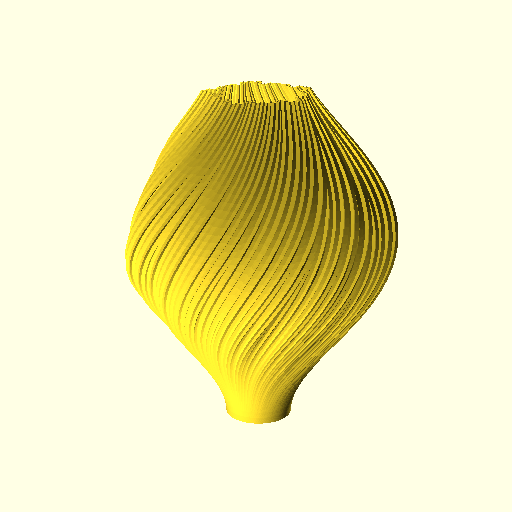

In [7]:
def radius(x):
    a = 3.0; b = 0.1; c = 0.01
    return a*x**2*(1.1 - x)**2 + c*x + b

opening_radius = 10.0
def koch_lampshade(i):
    samples = 5
    iterations = 3
    scale_up = opening_radius / radius(0.0)
    height = 1.0 * scale_up
    r = scale_up * radius(i)
    spin = i* pi/2

    lerp_function = i**1.5

    c = circle(r, samples * 4**iterations, spin)
    koch = kochify(circle(r, samples, spin), iterations, max_iterations = iterations)
    l = lerp_shapes(c, koch, lerp_function)
    return translate(l, [0,0,i*height])

save_to_stl_and_view("lampshade_{}mm".format(opening_radius), koch_lampshade)

Compiling design (CSG Products normalization)...
Normalized CSG tree has 1 elements



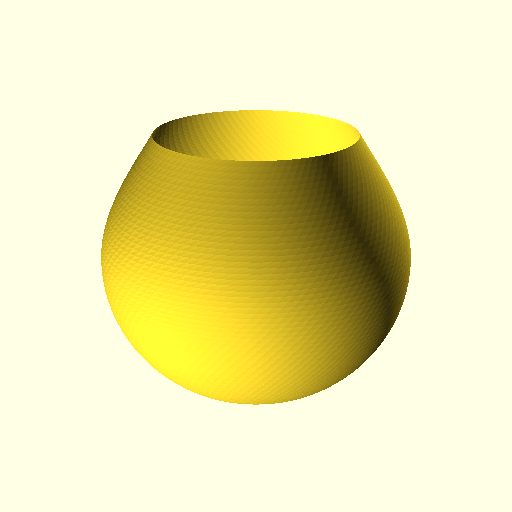

In [8]:
opening_radius = 60.0
def large_pot_smooth_bulb(i):
    from math import sqrt
    samples = 100
    scale_up = opening_radius / bulb_radius(1.0)

    spin = i* pi/2
    height = 150
    r = bulb_radius(i) * scale_up

    c = circle(r, samples, spin)
    return translate(c, [0,0,i*height])


f = large_pot_smooth_bulb
save_to_stl_and_view("{}_{}mm_opening".format(f.__name__, opening_radius), f)

Compiling design (CSG Products normalization)...
Normalized CSG tree has 1 elements



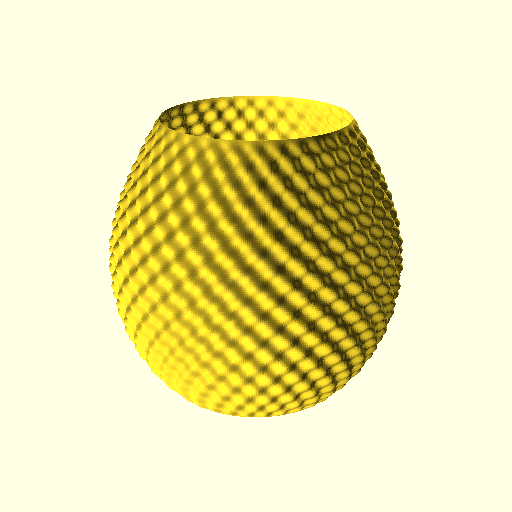

In [9]:
opening_radius = pot_diameters["medium"]
samples = 500
def bumpy(i):
    scale_up = opening_radius / bulb_radius(1.0)
    height = 1.0 * scale_up
    r = scale_up * bulb_radius(i)
    
    a = 100.0; b = 0.98;
    sigmoid = 1 / (1 + exp(a*(i-b)))

    def swirly_shape(t): return r + 0.03*sin(10*2*pi*i) * r*sin(30.0*t) * sigmoid
    p = polar(swirly_shape, samples, theta = 0)
    
    return translate(p, [0,0,i*height])


f = bumpy
save_to_stl_and_view("{}_{}mm_opening".format(f.__name__, opening_radius), f, samples = samples//3)

Compiling design (CSG Products normalization)...
Normalized CSG tree has 1 elements



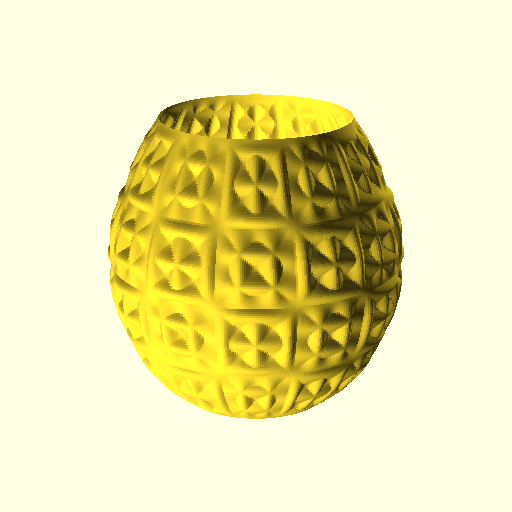

In [10]:
opening_radius = 74.0 / 2.0
samples = 500
def woven(i):
    scale_up = opening_radius / bulb_radius(1.0)
    height = 1.0 * scale_up
    r = scale_up * bulb_radius(i)
    
    a = 100.0; b = 0.98;
    sigmoid = 1 / (1 + exp(a*(i-b)))

    n = 1.0
    def swirly_shape(t): 
        return r \
            + 0.03*sigmoid*max(sin(2*2*pi*i)**n * r*sin(10.0*3.0*t)**n,sin(10.0*2*pi*i)**n * r*sin(2.0*3.0*t)**n)
    p = polar(swirly_shape, samples, theta = 0)
    
    return translate(p, [0,0,i*height])


f = woven
save_to_stl_and_view("{}_{}mm_opening".format(f.__name__, opening_radius), f, samples = samples//3)

Compiling design (CSG Products normalization)...
Normalized CSG tree has 1 elements



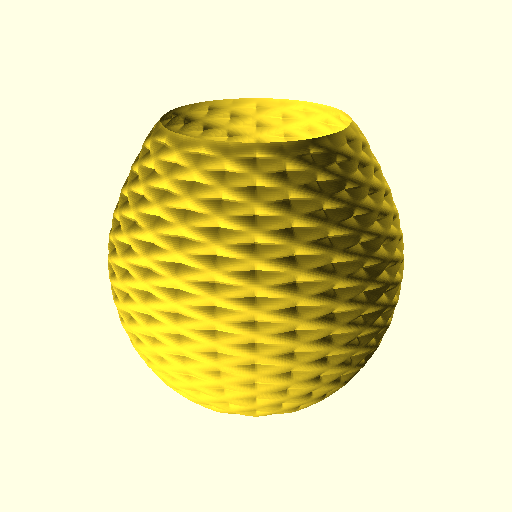

In [11]:
opening_radius = pot_diameters["medium"]
samples = 600

def smooth_max(args, softness = 10):
    n = softness
    return sum(x**n for x in args)**(1/n)

def woven_2(i):
    scale_up = opening_radius / bulb_radius(1.0)
    height = 1.0 * scale_up
    r = scale_up * bulb_radius(i)
    
    a = 100.0; b = 0.98;
    sigmoid = 1 / (1 + exp(a*(i-b)))

    def swirly_shape(t): 
        return r \
            + r*0.05*sigmoid*smooth_max((np.sin(3*2*(t+2*pi*i)),np.sin(3*2*(t-2*pi*i))))
    p = polar(swirly_shape, samples)
    
    return translate(p, [0,0,i*height])


f = woven_2
save_to_stl_and_view("{}_{}mm_opening".format(f.__name__, opening_radius), f, samples = samples//3)

Compiling design (CSG Products normalization)...
Normalized CSG tree has 1 elements



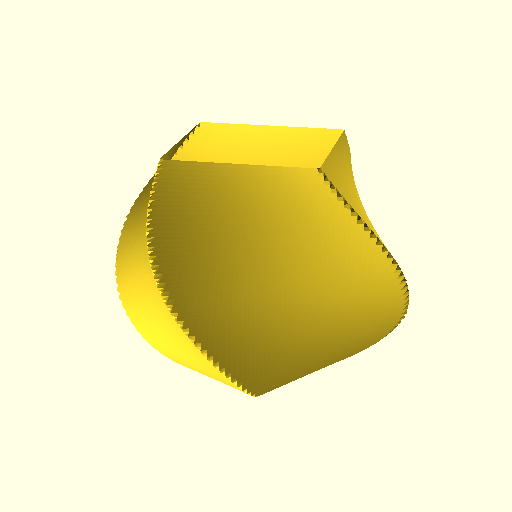

In [12]:
opening_radius = pot_diameters["medium"]
samples = 200

def sharp(i):
    scale_up = opening_radius / bulb_radius(1.0)
    height = 1.0 * scale_up
    r = scale_up * bulb_radius(i)
    
    a = 100.0; b = 0.98;
    sigmoid = 1 / (1 + exp(a*(i-b)))

    def pointy(t): 
        return r*1/max(abs(cos(t)), abs(sin(t)))
    p = polar(pointy, samples, theta = i*1.0)
    
    return translate(p, [0,0,i*height])


f = sharp
save_to_stl_and_view("{}_{}mm_opening".format(f.__name__, opening_radius), f, samples = samples//3)

Compiling design (CSG Products normalization)...
Normalized CSG tree has 1 elements



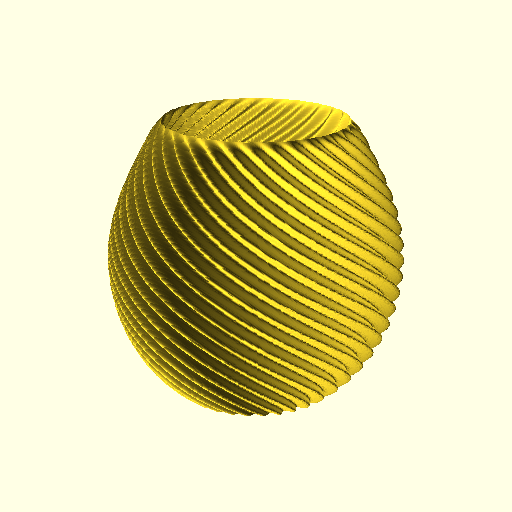

In [13]:
opening_radius = pot_diameters["medium"]
samples = 1000

def smooth_max(args, softness = 10):
    n = softness
    return sum(x**n for x in args)**(1/n)

def woven_3(i):
    scale_up = opening_radius / bulb_radius(1.0)
    height = 1.0 * scale_up
    r = scale_up * bulb_radius(i)
    
    a = 100.0; b = 0.98;
    sigmoid = 1 / (1 + exp(a*(i-b)))

    def swirly_shape(t): 
        return r \
            + r*0.05*sigmoid*(np.sin(15*2*(t+pi*i)))
    p = polar(swirly_shape, samples)
    
    return translate(p, [0,0,i*height])


f = woven_3
save_to_stl_and_view("{}_{}mm_opening".format(f.__name__, opening_radius), f, samples = samples//3)